# Clasificador de Clientes de Empresa de Telecom
Conjunto de Datos de Kaggle [Telco Customer Churn](https://www.kaggle.com/blastchar/telco-customer-churn) enfocado a programas de retención de clientes


# Bibliotecas

In [41]:
import numpy as np
import pandas as pd

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#funciones específicas de Sckit-learn
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc
#para exportar el gráfico como archivo.dot
from sklearn.tree import export_graphviz

#para visualizar el arbol desde el formato .dot
from IPython.display import Image
from pydotplus import graph_from_dot_data


# Funciones

In [42]:
def correlacion(dataframe, grafica=True, matrix=False):
    '''Devuelve la matriz de correlación de un dataframe
    y sí grafica=True, muestra un mapa de calor de la matriz de correlación'''
    corr = dataframe.corr()
    if grafica==True:
      fig = plt.figure(figsize = (25, 20))
      ax = sns.heatmap(corr,
                       vmin = -1,
                       vmax = 1,
                       center = 0,
                       cmap = "coolwarm",
                       annot = True,
                       fmt=".2f",
                       square = True)
      ax.set_xticklabels(ax.get_xticklabels(),
                         rotation = 45,
                         horizontalalignment ='right')
    if matrix==True:
      return corr

In [43]:
def grafica_roc(clf, y_test):
    '''Grafica la curva ROC para el conjunto de prueba'''
    y_test_score = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve( y_test, y_test_score)
    roc_auc = auc(fpr, tpr)  #Area bajo la curva (AUC, por sus siglas en inglés)
    plt.figure()
    plt.plot(fpr, tpr, label="Curva ROC (area = %0.2f)" % roc_auc)
    plt.plot([0, 1], [0, 1], "--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic")
    plt.legend(loc="lower right")
    plt.show()

# 1. Lectura de datos y breve exploración

In [44]:
df = pd.read_csv('https://raw.githubusercontent.com/AnIsAsPe/ClasificadorClientesTelecom/master/Datos/WA_Fn-UseC_-Telco-Customer-Churn.csv')

df.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [46]:
#Ver valores únicos de cada variable
df.nunique()

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

## 2. Preprocesamiento


### Se eliminan las variables innecesarias


In [47]:
df = df.set_index('customerID')

df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Transformación de variables y manejo de valores nulos

In [48]:
#Convertimos TotalCharges a numérica.

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [49]:
#¿Cuántos valores nulos quedaron?

print(df['TotalCharges'].isnull().sum())

df[df['TotalCharges'].isnull()]

11


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,
4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No


In [50]:
#Remplazamos por 0 los valores nulos
df = df.fillna(value=0)

### Binarización de variables

In [51]:
#Revisamos las categorías y frecuencias de cada variable de tipo "objeto"

df_obj = df.select_dtypes("object")

for col in df_obj.columns:
    print (col)
    print (df[col].value_counts(),'\n')

gender
Male      3555
Female    3488
Name: gender, dtype: int64 

Partner
No     3641
Yes    3402
Name: Partner, dtype: int64 

Dependents
No     4933
Yes    2110
Name: Dependents, dtype: int64 

PhoneService
Yes    6361
No      682
Name: PhoneService, dtype: int64 

MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: MultipleLines, dtype: int64 

InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: InternetService, dtype: int64 

OnlineSecurity
No                     3498
Yes                    2019
No internet service    1526
Name: OnlineSecurity, dtype: int64 

OnlineBackup
No                     3088
Yes                    2429
No internet service    1526
Name: OnlineBackup, dtype: int64 

DeviceProtection
No                     3095
Yes                    2422
No internet service    1526
Name: DeviceProtection, dtype: int64 

TechSupport
No                     3473
Yes                    2044
No internet servi

In [52]:
yes_columns = [col for col in df_obj.columns if 'Yes' in df_obj[col].unique()]
for col in yes_columns:
    df[col] = np.where(df[col]=='Yes',1,0)

In [53]:
# Vemos un ejemplo del resultado en una "yes_columns" y observamos que ahora es una columna numérica
print(df['MultipleLines'].dtype)
df['MultipleLines'].value_counts()

int64


0    4072
1    2971
Name: MultipleLines, dtype: int64

In [54]:
df.info()   # todas las yes_columns ahora son numéricas

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   int64  
 3   Dependents        7043 non-null   int64  
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   int64  
 6   MultipleLines     7043 non-null   int64  
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   int64  
 9   OnlineBackup      7043 non-null   int64  
 10  DeviceProtection  7043 non-null   int64  
 11  TechSupport       7043 non-null   int64  
 12  StreamingTV       7043 non-null   int64  
 13  StreamingMovies   7043 non-null   int64  
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   int64  
 16  PaymentMethod     7043 non-null 

In [55]:
print(df.shape)
print(df.columns)

(7043, 20)
Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')


In [56]:
df.select_dtypes("object").columns

Index(['gender', 'InternetService', 'Contract', 'PaymentMethod'], dtype='object')

In [57]:
#Utilizamos one-hot encoding para convertir variables categoricos a binarias (con ceros y unos)
df = pd.get_dummies(df, drop_first=True)
print(df.shape, '\n', df.columns)

(7043, 24) 
 Index(['SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService',
       'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling',
       'MonthlyCharges', 'TotalCharges', 'Churn', 'gender_Male',
       'InternetService_Fiber optic', 'InternetService_No',
       'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')


In [58]:
#Llevar columna de clase (Churn) hasta la última posición

df = df[[c for c in df if c != 'Churn'] + ['Churn']]

print(df.shape)

df.head()

(7043, 24)


,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,...,TotalCharges,gender_Male,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,0,1,0,1,0,0,0,1,0,0,...,29.85,0,0,0,0,0,0,1,0,0
5575-GNVDE,0,0,0,34,1,0,1,0,1,0,...,1889.50,1,0,0,1,0,0,0,1,0
3668-QPYBK,0,0,0,2,1,0,1,1,0,0,...,108.15,1,0,0,0,0,0,0,1,1
7795-CFOCW,0,0,0,45,0,0,1,0,1,1,...,1840.75,1,0,0,1,0,0,0,0,0
9237-HQITU,0,0,0,2,1,0,0,0,0,0,...,151.65,0,1,0,0,0,0,1,0,1


In [59]:
print('Número de columnas: ', df.shape[1], '\n')
print('Número de valores en cada columna: ')
df.nunique()

Número de columnas:  24 

Número de valores en cada columna: 


SeniorCitizen                               2
Partner                                     2
Dependents                                  2
tenure                                     73
PhoneService                                2
MultipleLines                               2
OnlineSecurity                              2
OnlineBackup                                2
DeviceProtection                            2
TechSupport                                 2
StreamingTV                                 2
StreamingMovies                             2
PaperlessBilling                            2
MonthlyCharges                           1585
TotalCharges                             6531
gender_Male                                 2
InternetService_Fiber optic                 2
InternetService_No                          2
Contract_One year                           2
Contract_Two year                           2
PaymentMethod_Credit card (automatic)       2
PaymentMethod_Electronic check    

<Axes: >

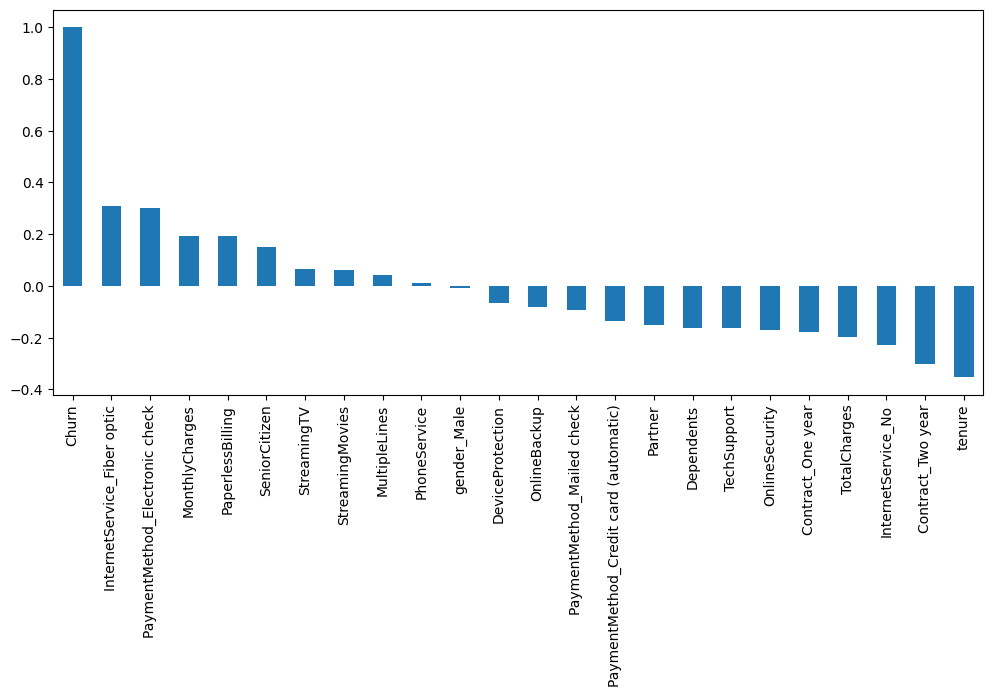

In [60]:
#Correlación de cada variable con Churn
plt.figure(figsize = (12,5))
df.corr()['Churn'].sort_values(ascending = False).plot(kind ='bar',)

# Árbol de Decisión

## Creación de subconjuntos de entrenamiento y prueba

In [61]:
#Separar las etiquetas del conjunto de datos

y = df['Churn']
X = df.drop('Churn', axis=1)

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    shuffle=True,
                                                    random_state=261)


In [63]:
# ¿Cómo son los conjuntos de entrenamiento y prueba?
print("TRAINING SET")
print("X: ", X_train.shape)
print("y: ", y_train.shape)
print('Clientes que cancelan:{:7.3f}%'.format(y_train.mean()*100),'\n')

print("TEST SET")
print("X: ", X_test.shape)
print("y: ", y_test.shape)
print('Clientes que cancelan:{:7.3f}%'.format(y_test.mean()*100))

TRAINING SET
X:  (4930, 23)
y:  (4930,)
Clientes que cancelan: 26.572% 

TEST SET
X:  (2113, 23)
y:  (2113,)
Clientes que cancelan: 26.455%


## Entrenamiento y prueba del modelo

In [64]:
profundidad = None

#Entrenamiento del modelo
clasificador = DecisionTreeClassifier( max_depth=profundidad,
                                      criterion="entropy",
                                      random_state=0)
clasificador.fit(X_train, y_train)

print("La profundida del árbol es: {}".format(clasificador.get_depth()))

#Predicción y evaluación sobre el conjunto de entrenamiento
y_pred_train = clasificador.predict(X_train)
precision_train = accuracy_score(y_train, y_pred_train)*100
print("Precisión conjunto de entrenamiento: {:4.2f}%".format(precision_train))

#Predicción y evaluación sobre el conjunto de prueba
y_pred_test = clasificador.predict(X_test)
precision_test = accuracy_score(y_test, y_pred_test)*100
print("Precisión conjunto de prueba: {:4.2f}%".format(precision_test),'\n')


La profundida del árbol es: 31
Precisión conjunto de entrenamiento: 99.80%
Precisión conjunto de prueba: 73.21% 



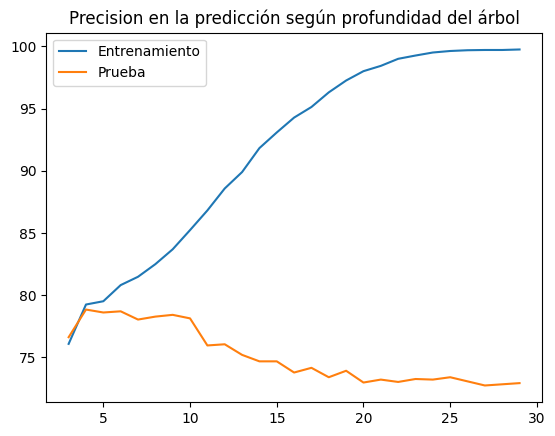

In [66]:
#Entrenamiento y prueba del modelo con distintos niveles de profunidad

clf = {}
y_pred_train = {}
y_pred_test = {}
precision_train={}
precision_test = {}

for p in range(3,30):
    #Entrenamiento del modelo
    clf[p] = DecisionTreeClassifier(max_depth = p,
                               criterion = "entropy",
                               random_state = 0).fit(X_train, y_train)

    #Predicción y evaluación sobre el conjunto de entrenamiento
    y_pred_train[p] = clf[p].predict(X_train)
    precision_train[p] = accuracy_score(y_train, y_pred_train[p])*100

    #Predicción y evaluación sobre el conjunto de prueba
    y_pred_test[p] = clf[p].predict(X_test)
    precision_test[p] = accuracy_score(y_test, y_pred_test[p])*100

precision_df = pd.DataFrame( {'Entrenamiento':precision_train,
                           'Prueba': precision_test})

precision.plot.line(
    title ='Precision en la predicción según profundidad del árbol')
plt.show()

In [67]:
precision_df

,Entrenamiento,Prueba
3,76.085193,76.620918
4,79.249493,78.845244
5,79.513185,78.608613
6,80.811359,78.703265
7,81.480730,78.040700
8,82.494929,78.277331
9,83.691684,78.419309
10,85.233266,78.135353
11,86.815416,75.958353
12,88.580122,76.053005


## Visualización del árbol de decisión

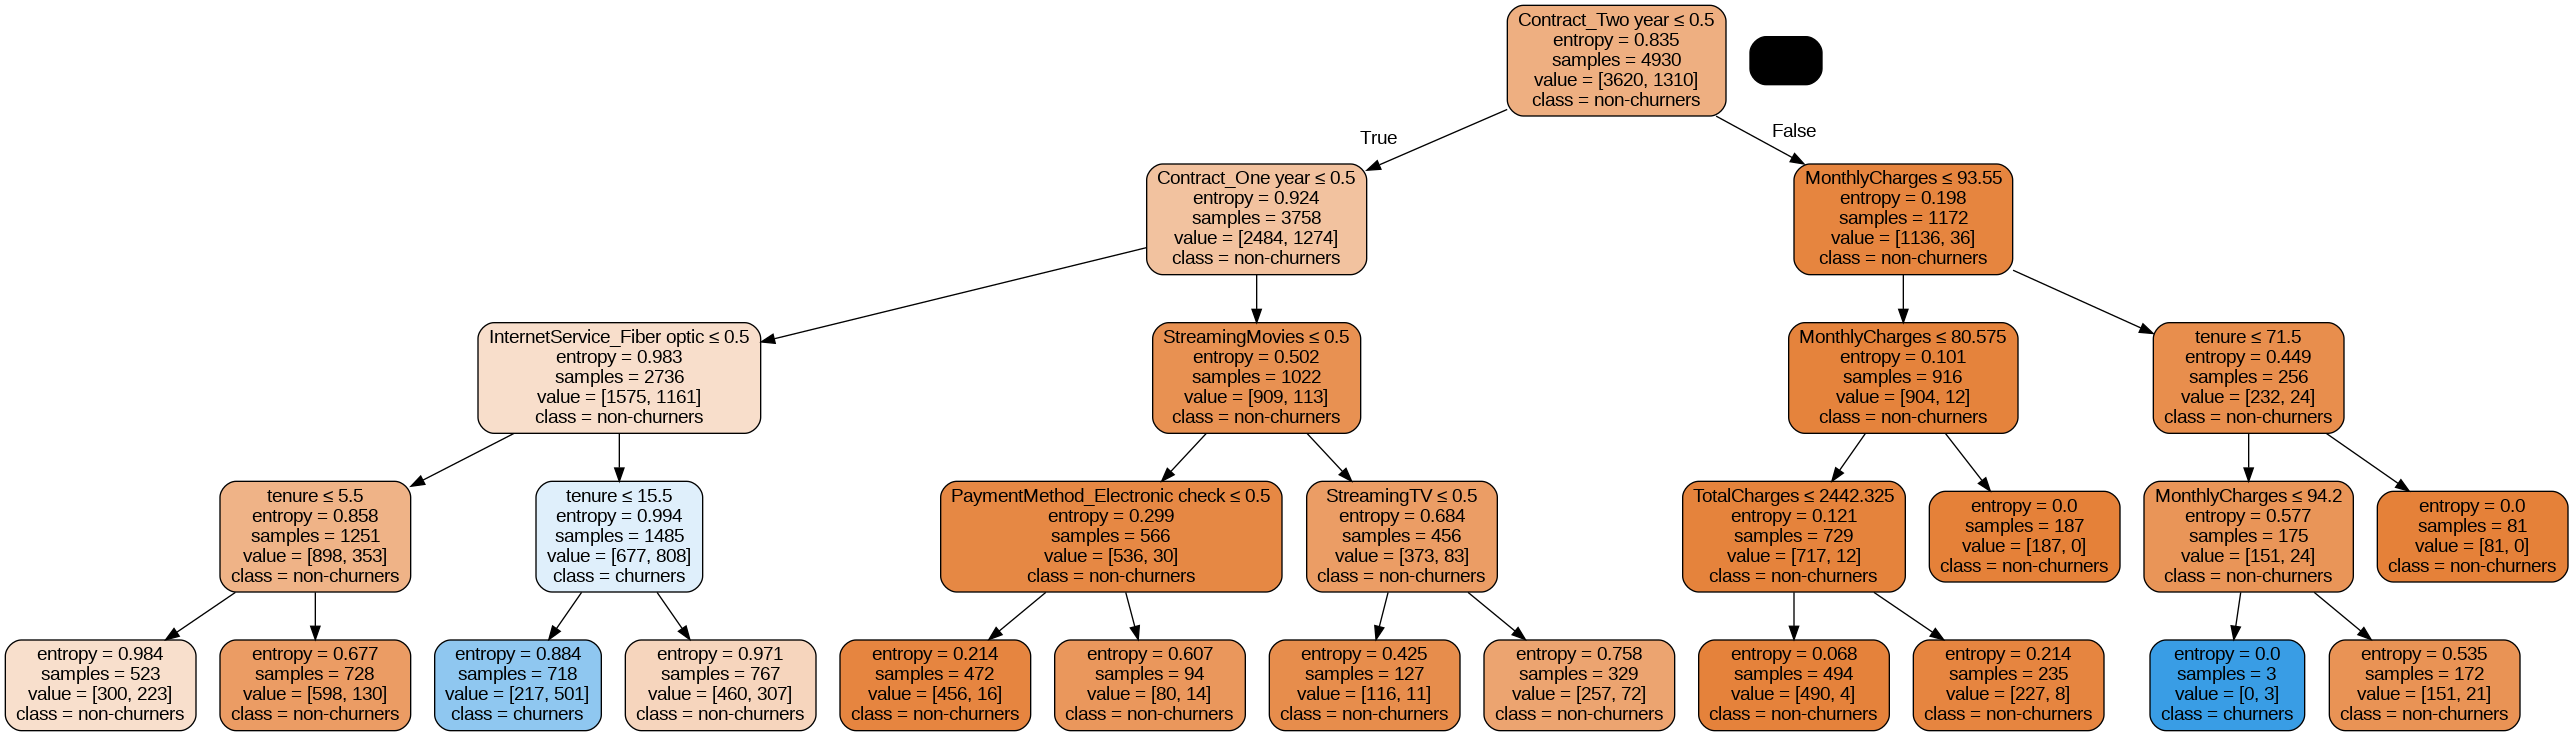

In [68]:
#Método 1 para graficar el arbol exportando el arbol como un archivo .dot

dot_data = export_graphviz(clf[4], rounded = True,
                           filled = True,
                           special_characters = True,
                           feature_names = X.columns,
                           max_depth = 4,
                           class_names = ['non-churners','churners'])

graph = graph_from_dot_data(dot_data)

Image(graph.create_png( ))

## Importancia de cada variable de acuerdo al modelo

<Axes: >

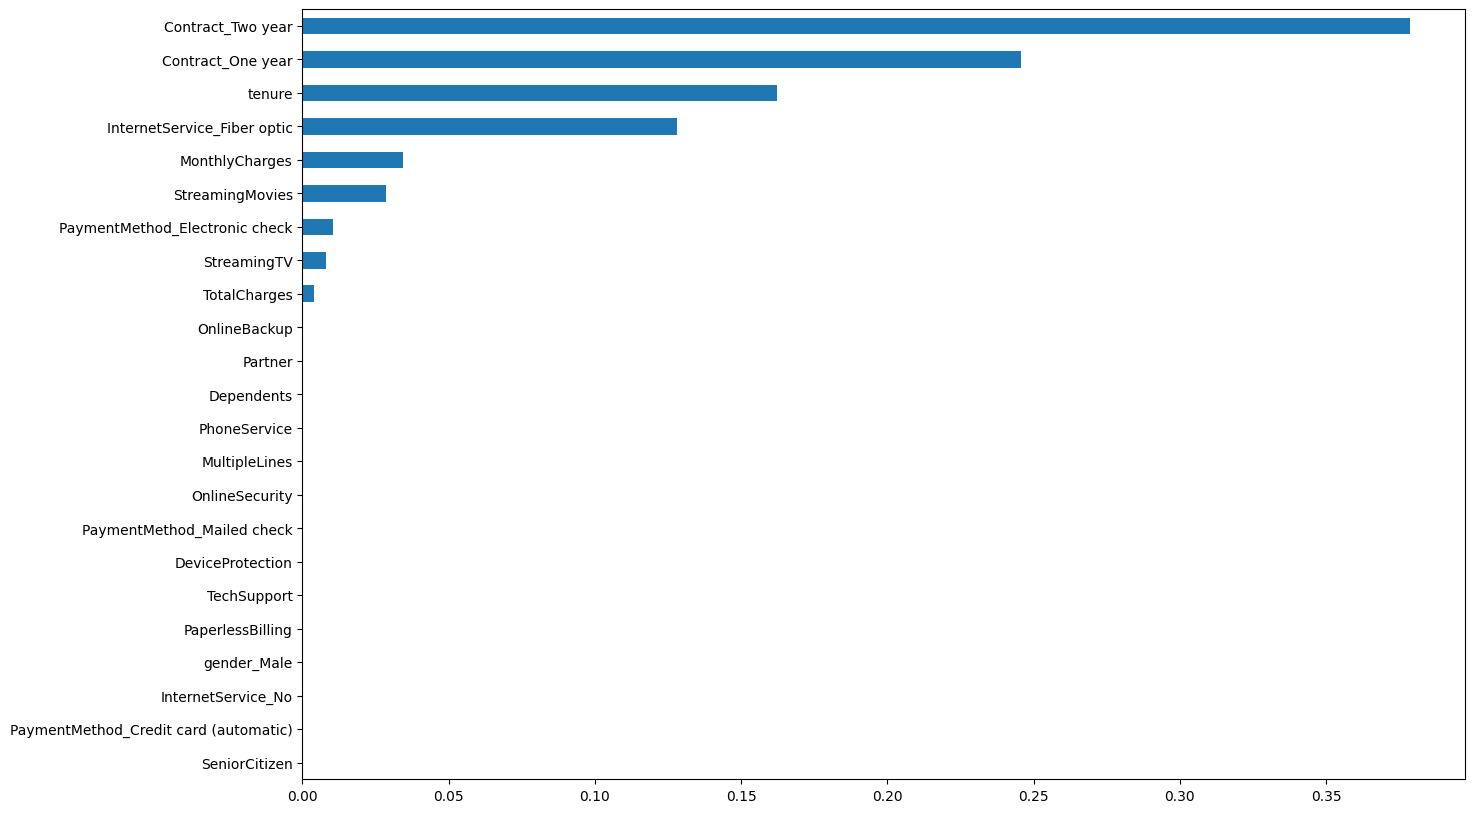

In [70]:
weights = pd.Series(clf[4].feature_importances_,
                    index=X.columns.values)

weights.sort_values().plot(kind = 'barh',figsize=(15, 10))

## Evaluació del modelo Matriz de confusión

**Matriz de confusión**

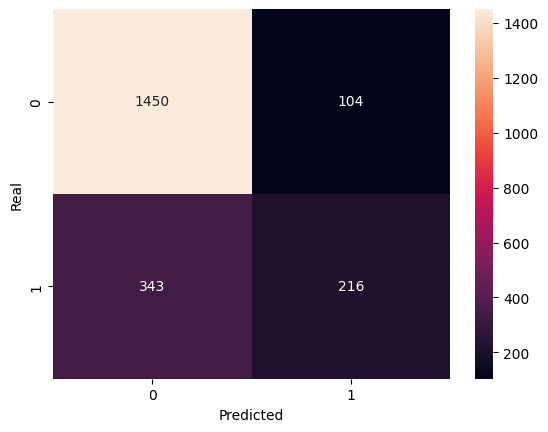

In [71]:
#Matriz de confusión

import seaborn as sns

data = {'y_Real':  y_test,
        'y_Prediccion': y_pred_test[4]
        }

df = pd.DataFrame(data)
confusion_matrix = pd.crosstab(df['y_Real'], df['y_Prediccion'], rownames=['Real'], colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True, fmt='g')
plt.show()


In [74]:
clf[4].predict(X_test)[0:20]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

In [75]:
pd.DataFrame(clf[4].predict_proba(X_test)).head(20)

,0,1
0,0.599739,0.400261
1,0.821429,0.178571
2,0.599739,0.400261
3,0.877907,0.122093
4,0.573614,0.426386
5,0.781155,0.218845
6,0.991903,0.008097
7,0.573614,0.426386
8,0.991903,0.008097
9,0.991903,0.008097


In [78]:
umbral = 0.35 # por arriba del cual se clasificaría como clase 1
prediccion_test = np.where( clf[4].predict_proba(X_test)[:, 1] > umbral, 1, 0)
prediccion_test[0:20]

array([1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0])

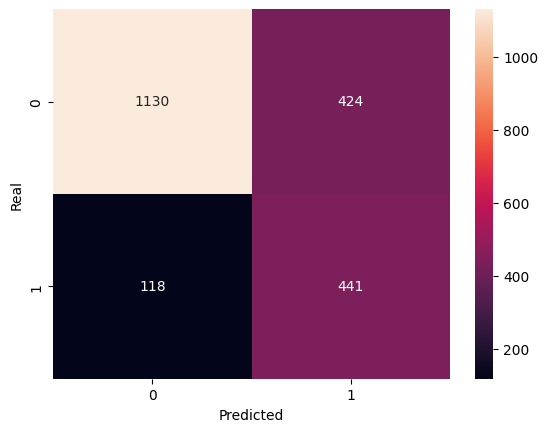

In [79]:
data = {'y_Real':  y_test,
        'y_Prediccion': prediccion_test
        }

df = pd.DataFrame(data)
confusion_matrix = pd.crosstab(df['y_Real'], df['y_Prediccion'], rownames=['Real'], colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True, fmt='g')
plt.show()

###**[Curva ROC](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html)**

* eje x ----  Specificity (proporción de falsos positivos (*fpr*) )
* eje y ----  Recall/Sensitivity (proporción de verdaderos positivos (*tpr*))



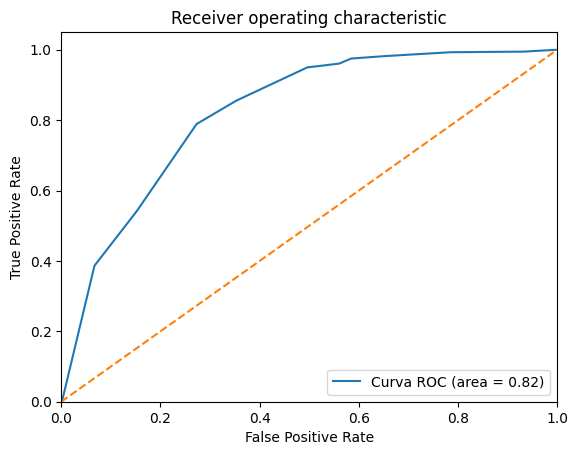

In [81]:
grafica_roc(clf[4], y_test)


# Bosque Aleatorio

## Entrenamiento y prueba


In [82]:
from sklearn.ensemble import RandomForestClassifier

In [83]:
clf_rf = RandomForestClassifier(n_estimators=1000,  random_state =0,
                                criterion='entropy').fit(X_train, y_train)


y_pred = clf_rf.predict(X_test)
print("Precisión del modelo Bosque Aleatorio en el conjunto de prueba: {:4.2f}%".format(accuracy_score(y_test, y_pred)*100))


Precisión del modelo Bosque Aleatorio en el conjunto de prueba: 79.03%


<Axes: >

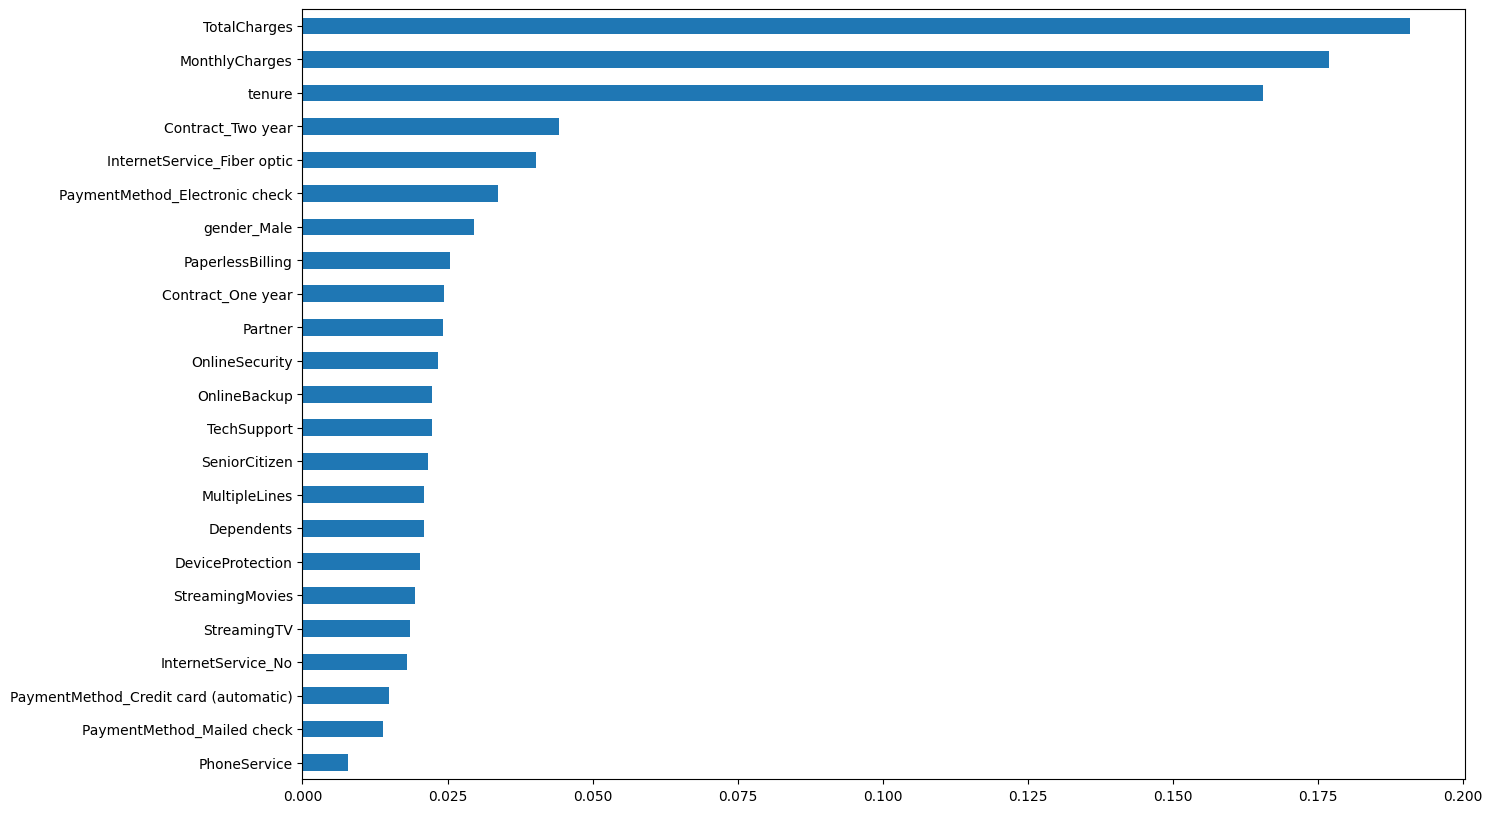

In [84]:
importances = clf_rf.feature_importances_
weights = pd.Series(importances,
                    index=X.columns.values)
weights.sort_values().plot(kind = 'barh',figsize=(15, 10))

In [85]:
weights.sum()

1.0000000000000002

In [86]:
clf_rf.predict_proba(X_test)

array([[0.268, 0.732],
       [0.699, 0.301],
       [0.621, 0.379],
       ...,
       [0.826, 0.174],
       [0.813, 0.187],
       [0.675, 0.325]])